In [1]:
import torch
import torch.nn as nn
import os
import mlp.data_providers as data_providers
import numpy as np
from storage_utils import load_statistics
from collections import OrderedDict
from model_architectures import ConvolutionalNetwork
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
val_data = data_providers.EMNISTDataProvider('valid', batch_size=1)
test_data = data_providers.EMNISTDataProvider('test', batch_size=1)

KeysView(<numpy.lib.npyio.NpzFile object at 0x10e983fd0>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x10eae6208>)


In [4]:
model_names = ['32_filters', '64_filters', '128_filters', '256_filters']
models = OrderedDict()
stats = OrderedDict()

batch_size = 128
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_type = 'max_pooling'
possible_num_filters = [32, 64, 128, 256]
num_layers = 4
num_epochs = 50
weight_decay_coefficient = 0
seed = 7112018
use_gpu = True

In [5]:
def rename_dict_key(old_dict):
    new_dict = OrderedDict()
    for key in old_dict.keys():
        new_dict[key[6:]] = old_dict[key]
    return new_dict

In [8]:
# load summary stats
for model_name, num_filters in zip(model_names, possible_num_filters):
    experiment_log_dir = './outputs/' + model_name + '/result_outputs/'
    summary = load_statistics(experiment_log_dir, 'summary.csv')
    stats[model_name] = summary

In [23]:
# training accuracy plot
plt.figure(figsize=(8,8), dpi=1000)
colors = ['r', 'g', 'b', 'm']

for model_name, c in zip(model_names,  colors):
    statistics = stats[model_name]
    train_acc = statistics['train_acc']
    valid_acc = statistics['val_acc']
    plt.plot(np.arange(1, len(train_acc)+1), np.array(train_acc, dtype='float') * 100, label=model_name+'_train', c=c)
    plt.plot(np.arange(1, len(valid_acc)+1), np.array(valid_acc, dtype='float') * 100, label=model_name+'_valid', c=c, linestyle='--')
    
plt.legend(loc=4, fontsize=14)
plt.ylim((60, 100))
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
# plt.title('Accuracy', fontsize=20)
plt.savefig('./plots/1_2_num_filters.pdf', dpi=1000)

Text(0.5,1,'Loss')

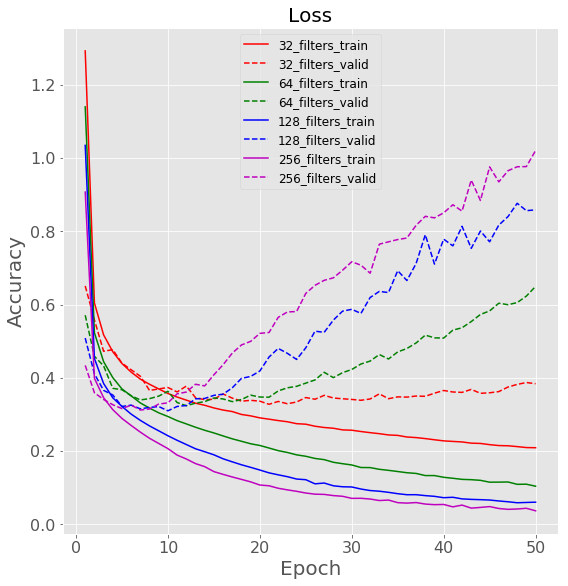

In [10]:
# training accuracy plot
plt.figure(figsize=(8,8))
colors = ['r', 'g', 'b', 'm']

for model_name, c in zip(model_names,  colors):
    statistics = stats[model_name]
    train_loss = statistics['train_loss']
    valid_loss = statistics['val_loss\n']
    plt.plot(np.arange(1, len(train_loss)+1), np.array(train_loss, dtype='float'), label=model_name+'_train', c=c)
    plt.plot(np.arange(1, len(valid_loss)+1), np.array(valid_loss, dtype='float'), label=model_name+'_valid', c=c, linestyle='--')
    
plt.legend(loc=0, fontsize=12)
# plt.ylim((50, 100))
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.title('Loss', fontsize=20)

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

best_idxs = []
best_valid_accs = []
best_train_accs = []
num_params = []
# load best models
for model_name, num_filters in zip(model_names, possible_num_filters):
    conv_model = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type,
        num_output_classes=47, num_filters=num_filters, num_layers=num_layers, use_bias=True)
    
    model_save_dir = './outputs/' + model_name + '/saved_models/'
    path = os.path.join(model_save_dir, "{}_{}".format("train_model", 49))
    
    device = torch.device('cpu')
    state = torch.load(path, map_location=device)
    best_val_model_idx, best_val_model_acc = state['best_val_model_idx'], state['best_val_model_acc']
    best_idxs.append(best_val_model_idx)
    best_valid_accs.append(best_val_model_acc)
    
    best_train_acc = stats[model_name]['train_acc'][best_val_model_idx]
    best_train_accs.append(best_train_acc)
    
    path = os.path.join(model_save_dir, "{}_{}".format("train_model", best_val_model_idx))
    state = torch.load(path, map_location=device)
    new_state = rename_dict_key(state['network'])
    conv_model.load_state_dict(state_dict=new_state)
    conv_model.eval()
    models[model_name] = conv_model
    num = count_parameters(conv_model)
    num_params.append(num)

Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 32, 28, 28])
torch.Size([128, 32, 15, 15])
torch.Size([128, 32, 15, 15])
torch.Size([128, 32, 8, 8])
torch.Size([128, 32, 8, 8])
torch.Size([128, 32, 5, 5])
torch.Size([128, 32, 5, 5])
torch.Size([128, 32, 3, 3])
shape before final linear layer torch.Size([128, 32, 2, 2])
Block is built, output volume is torch.Size([128, 47])
Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 64, 28, 28])
torch.Size([128, 64, 15, 15])
torch.Size([128, 64, 15, 15])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 5, 5])
torch.Size([128, 64, 5, 5])
torch.Size([128, 64, 3, 3])
shape before final linear layer torch.Size([128, 64, 2, 2])
Block is built, output volume is torch.Size([128, 47])
Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 128, 28, 28])
torch.Size([128, 128, 15, 15])
torch.Si

In [31]:
num_params

[34127, 123503, 468143, 1820975]

In [32]:
best_train_accs

['0.8934759122919335',
 '0.9165332906530089',
 '0.8934659090909091',
 '0.9119318181818182']

In [34]:
best_valid_accs

[0.8857977642276422, 0.8861153455284553, 0.8895452235772358, 0.889354674796748]

In [12]:
x, y = val_data.next()
x_test, y_test = torch.Tensor(x).float().to(device='cpu'), torch.Tensor(y).long().to(device='cpu')  # send data to device as torch tensors

In [13]:
def hook(module, inputdata, output):
    outputs.append(output)
    
feature_maps = OrderedDict()

for model_name in model_names:
    conv_model = models[model_name]
    outputs = []
    for layer_name in conv_model.layer_dict.keys():
        print(model_name + '_' + layer_name)
        h = conv_model.layer_dict[layer_name].register_forward_hook(hook)
        h_x = conv_model(x_test)
        h.remove()
        feature_maps[model_name + '_' + layer_name] = outputs[-1].detach().numpy()
    print(len(outputs))

32_filters_conv_0
32_filters_dim_reduction_max_pool_0
32_filters_conv_1
32_filters_dim_reduction_max_pool_1
32_filters_conv_2
32_filters_dim_reduction_max_pool_2
32_filters_conv_3
32_filters_dim_reduction_max_pool_3
8
64_filters_conv_0
64_filters_dim_reduction_max_pool_0
64_filters_conv_1
64_filters_dim_reduction_max_pool_1
64_filters_conv_2
64_filters_dim_reduction_max_pool_2
64_filters_conv_3
64_filters_dim_reduction_max_pool_3
8
128_filters_conv_0
128_filters_dim_reduction_max_pool_0
128_filters_conv_1
128_filters_dim_reduction_max_pool_1
128_filters_conv_2
128_filters_dim_reduction_max_pool_2
128_filters_conv_3
128_filters_dim_reduction_max_pool_3
8
256_filters_conv_0
256_filters_dim_reduction_max_pool_0
256_filters_conv_1
256_filters_dim_reduction_max_pool_1
256_filters_conv_2
256_filters_dim_reduction_max_pool_2
256_filters_conv_3
256_filters_dim_reduction_max_pool_3
8


In [17]:
def show_batch_feature_maps(outputs):
    grid_size = int(np.ceil((outputs.shape[0] ** 0.5)))
    fig, ax = plt.subplots(grid_size, grid_size)
    ax = ax.flatten()
    
    for i in range(outputs.shape[0]):
        ax[i].imshow(outputs[i], cmap='Greys')
        ax[i].axis('off')
    plt.show()
    
    return fig, ax

32_filters_conv_0


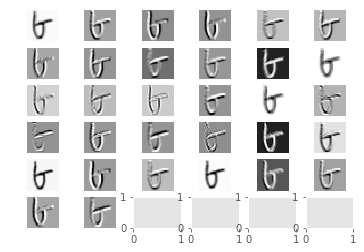

32_filters_dim_reduction_max_pool_0


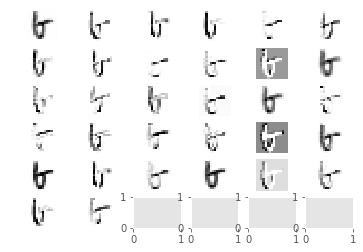

32_filters_conv_1


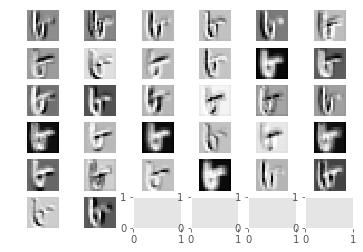

32_filters_dim_reduction_max_pool_1


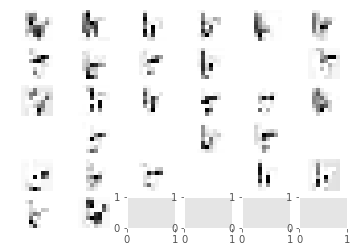

32_filters_conv_2


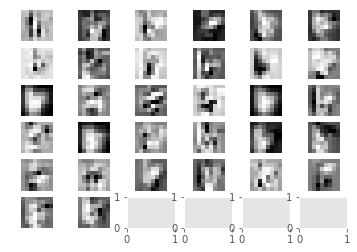

32_filters_dim_reduction_max_pool_2


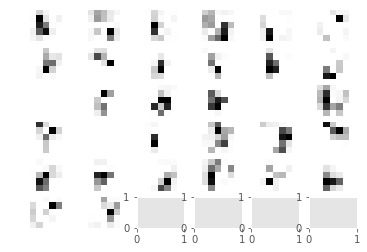

32_filters_conv_3


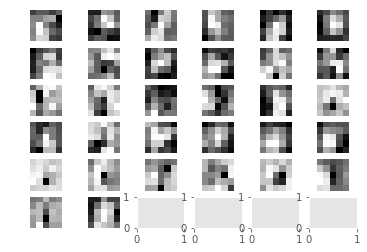

32_filters_dim_reduction_max_pool_3


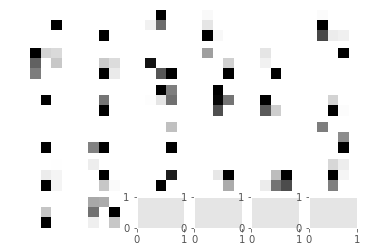

64_filters_conv_0


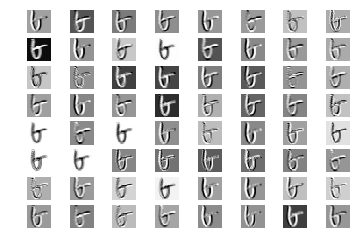

64_filters_dim_reduction_max_pool_0


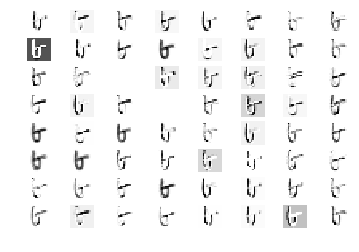

64_filters_conv_1


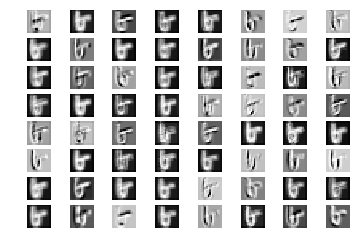

64_filters_dim_reduction_max_pool_1


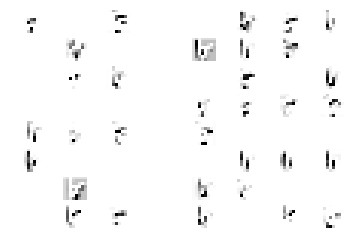

64_filters_conv_2


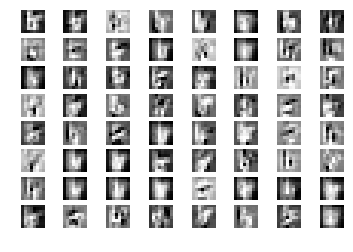

64_filters_dim_reduction_max_pool_2


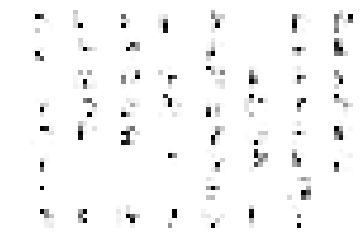

64_filters_conv_3


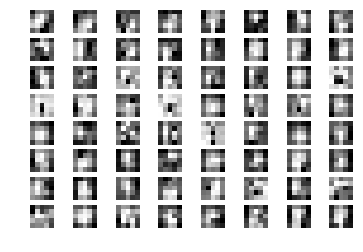

64_filters_dim_reduction_max_pool_3


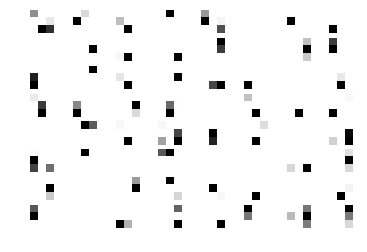

128_filters_conv_0


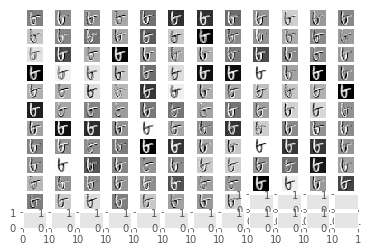

128_filters_dim_reduction_max_pool_0


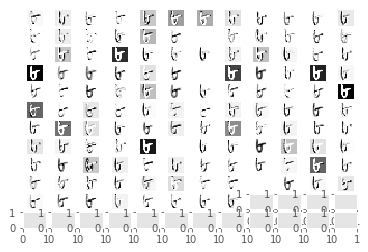

128_filters_conv_1


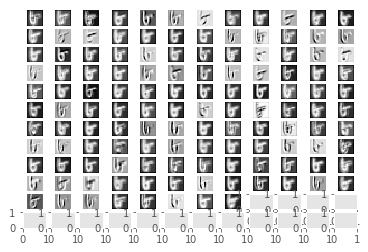

128_filters_dim_reduction_max_pool_1


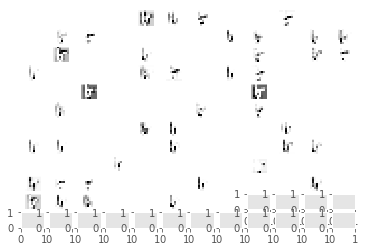

128_filters_conv_2


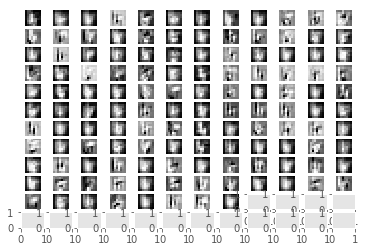

128_filters_dim_reduction_max_pool_2


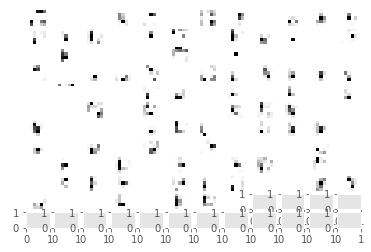

128_filters_conv_3


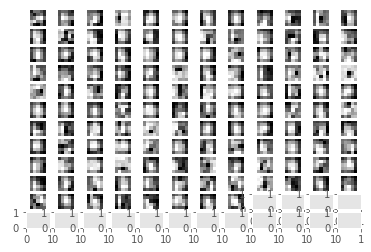

128_filters_dim_reduction_max_pool_3


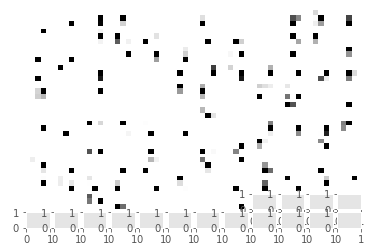

256_filters_conv_0


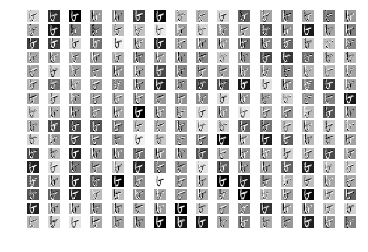

256_filters_dim_reduction_max_pool_0


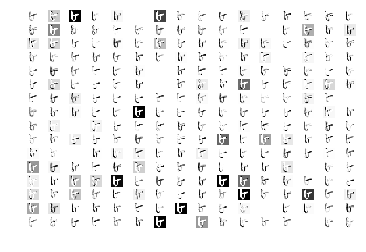

256_filters_conv_1


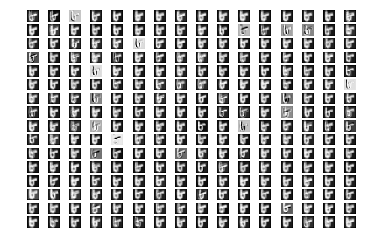

256_filters_dim_reduction_max_pool_1


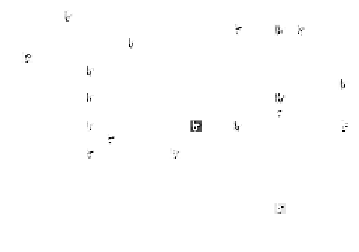

256_filters_conv_2


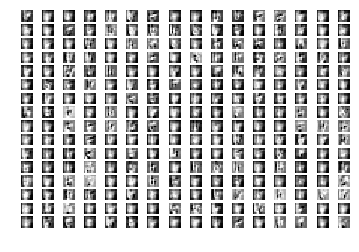

256_filters_dim_reduction_max_pool_2


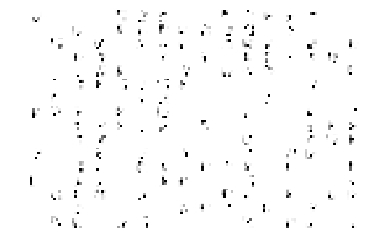

256_filters_conv_3


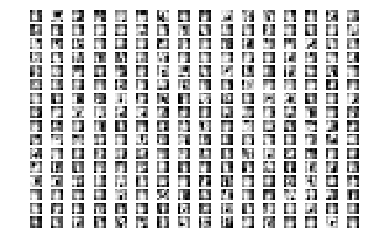

256_filters_dim_reduction_max_pool_3


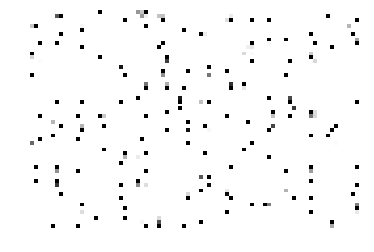

In [18]:
for model_name in model_names:
    conv_model = models[model_name]
    for layer_name in conv_model.layer_dict.keys():
        print(model_name + '_' + layer_name)
        outputs = feature_maps[model_name + '_' + layer_name][0]
        show_batch_feature_maps(outputs)